# ARIMA aplicado na serie temporal 01
## Cotacao do Dolar em relacao ao Real

In [1]:
import pandas as pd
import numpy as np
import warnings

from statsmodels.tsa.arima_model import ARIMA

# imports de modulos que estao definidos dentro do projeto
import data
import timeseries
import arima
import constants

import matplotlib.pyplot as plt
%matplotlib inline

## Transformacao da serie temporal 'MENSAL com duas amostras'

In [2]:
ts = data.load_timeseries01_monthly2()

#timeseries.plot_timeserie(ts)

In [3]:
ts_transform = timeseries.ts_transform1(ts)

#timeseries.plot_timeserie(ts_transform['ts_log']) # primeira transformacao
#timeseries.plot_timeserie(ts_transform['ts_log_diff']) # segunda transformacao

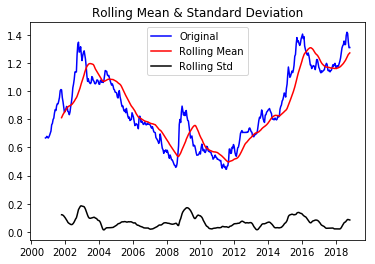

Results of Dickey-Fuller Test:
[FALHA] Test Statistic (-1.349799) > Critical Value 1 (-3.445685)
[FALHA] Test Statistic (-1.349799) > Critical Value 5 (-2.868301)
[FALHA] Test Statistic (-1.349799) > Critical Value 10 (-2.570371)
[FALHA] p-value (0.606093) > 0.05


In [4]:
timeseries.check_stationarity(ts_transform['ts_log'], window=24)

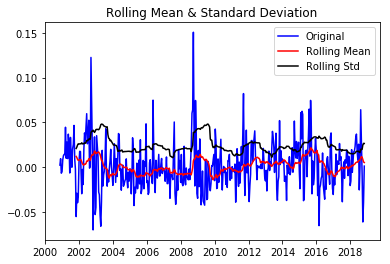

Results of Dickey-Fuller Test:
[SUCESSO] Test Statistic (-9.462374) < Critical Value 1 (-3.445685)
[SUCESSO] Test Statistic (-9.462374) < Critical Value 5 (-2.868301)
[SUCESSO] Test Statistic (-9.462374) < Critical Value 10 (-2.570371)
[SUCESSO] p-value (0.000000) < 0.05


In [5]:
timeseries.check_stationarity(ts_transform['ts_log_diff'], window=24)

## ARIMA aplicado na serie temporal 'MENSAL com duas amostras'

Parameter 'dataset' length:  433
Dataset 'train' length:  346
Dataset 'test' length:  87


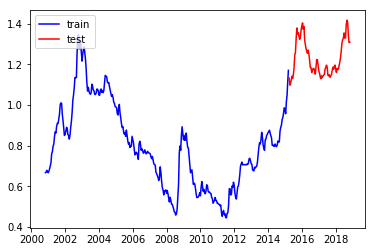

In [6]:
train, test = arima.split_dataset(ts_transform['ts_log'], porcentagem=constants.PORCENTAGEM, debug=True)

timeseries.plot_train_and_test(train, test)

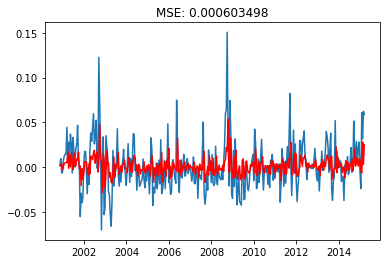

In [7]:
# depois do Grid Search
#Melhores parametros: ARIMA(0, 1, 1)
arima_params = (0, 1, 1)

model = ARIMA(train, order=arima_params)
results_ARIMA = model.fit(disp=-1)

#arima.print_dataframe_info(results_ARIMA.fittedvalues)

train_size = int(len(ts_transform['ts_log_diff']) * constants.PORCENTAGEM)
ts_train = ts_transform['ts_log_diff'][0:train_size]

#arima.print_dataframe_info(ts_train)

timeseries.plot_train_and_arima(ts_train, results_ARIMA)

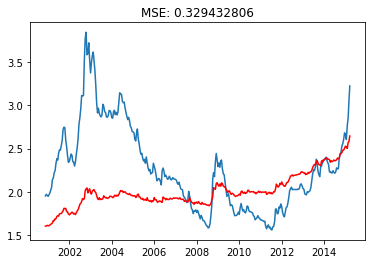

In [8]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)

predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pd.Series(train.iloc[0], index=train.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)

predictions_ARIMA = np.exp(predictions_ARIMA_log)
predictions_ARIMA = predictions_ARIMA.apply(lambda x: x*1.6)
predictions_ARIMA = predictions_ARIMA[1:]

#arima.print_dataframe_info(predictions_ARIMA)

train_size = int(len(ts) * constants.PORCENTAGEM)
ts_train = ts[1:train_size]

#arima.print_dataframe_info(ts_train)

timeseries.plot_train_and_predictions(ts_train, predictions_ARIMA)

Test MSE: 0.112458929


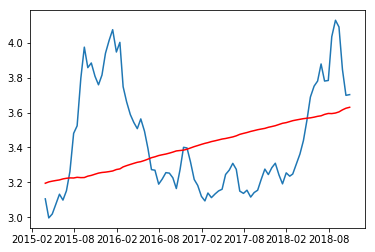

In [9]:
historical, predictions = arima.forecast(train, test, arima_params)

for i in range(len(predictions)):
    predictions[i] = predictions[i] - historical[i]/40
    
arima.plot_historical_and_predictions(historical, predictions, test)

## Transformacao da serie temporal 'MENSAL'

In [10]:
ts = data.load_timeseries01_monthly()

#timeseries.plot_timeserie(ts)

In [11]:
ts_transform = timeseries.ts_transform1(ts)

#timeseries.plot_timeserie(ts_transform['ts_log']) # primeira transformacao
#timeseries.plot_timeserie(ts_transform['ts_log_diff']) # segunda transformacao

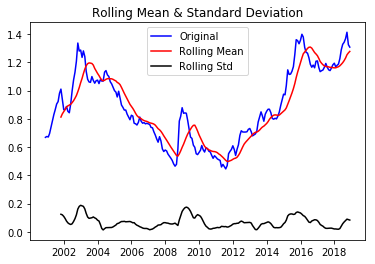

Results of Dickey-Fuller Test:
[FALHA] Test Statistic (-1.431590) > Critical Value 1 (-3.461136)
[FALHA] Test Statistic (-1.431590) > Critical Value 5 (-2.875079)
[FALHA] Test Statistic (-1.431590) > Critical Value 10 (-2.573986)
[FALHA] p-value (0.567042) > 0.05


In [12]:
timeseries.check_stationarity(ts_transform['ts_log'], window=12)

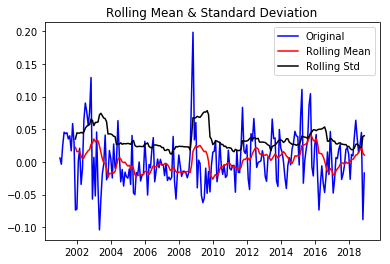

Results of Dickey-Fuller Test:
[SUCESSO] Test Statistic (-9.652797) < Critical Value 1 (-3.461136)
[SUCESSO] Test Statistic (-9.652797) < Critical Value 5 (-2.875079)
[SUCESSO] Test Statistic (-9.652797) < Critical Value 10 (-2.573986)
[SUCESSO] p-value (0.000000) < 0.05


In [13]:
timeseries.check_stationarity(ts_transform['ts_log_diff'], window=12)

## ARIMA aplicado na serie temporal 'MENSAL'

Parameter 'dataset' length:  217
Dataset 'train' length:  173
Dataset 'test' length:  44


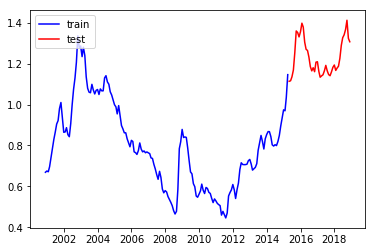

In [14]:
train, test = arima.split_dataset(ts_transform['ts_log'], porcentagem=constants.PORCENTAGEM, debug=True)

timeseries.plot_train_and_test(train, test)

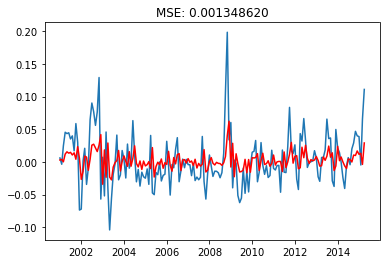

In [15]:
# depois do Grid Search
# Melhores parametros: ARIMA(0, 1, 1)
arima_params = (0, 1, 1)

model = ARIMA(train, order=arima_params)
results_ARIMA = model.fit(disp=-1)

#arima.print_dataframe_info(results_ARIMA.fittedvalues)

train_size = int(len(ts_transform['ts_log_diff']) * constants.PORCENTAGEM)
ts_train = ts_transform['ts_log_diff'][0:train_size]

#arima.print_dataframe_info(ts_train)

timeseries.plot_train_and_arima(ts_train, results_ARIMA)

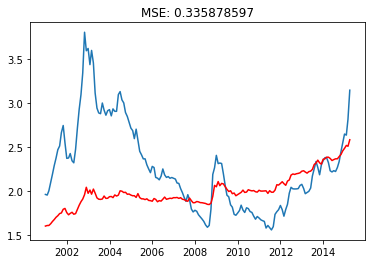

In [16]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)

predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pd.Series(train.iloc[0], index=train.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)

predictions_ARIMA = np.exp(predictions_ARIMA_log)
predictions_ARIMA = predictions_ARIMA.apply(lambda x: x*1.6)
predictions_ARIMA = predictions_ARIMA[1:]

#arima.print_dataframe_info(predictions_ARIMA)

train_size = int(len(ts) * constants.PORCENTAGEM)
ts_train = ts[1:train_size]

#arima.print_dataframe_info(ts_train)

timeseries.plot_train_and_predictions(ts_train, predictions_ARIMA)

Test MSE: 0.111434039


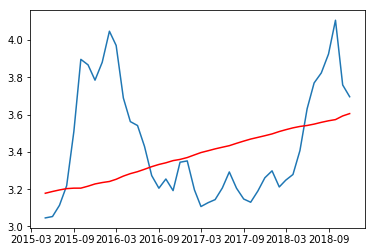

In [17]:
historical, predictions = arima.forecast(train, test, arima_params)

for i in range(len(predictions)):
    predictions[i] = predictions[i] - historical[i]/40
    
arima.plot_historical_and_predictions(historical, predictions, test)